<a href="https://colab.research.google.com/github/mralamdari/Computer-Vision-Projects/blob/main/Baman_Tracker_YoloV3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Step 0: Essentials

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
def imShow(path):
  image = cv2.imread(path)
  height, width = image.shape[:2]
  resized_image = cv2.resize(image,(3*width, 3*height), interpolation = cv2.INTER_CUBIC)

  fig = plt.gcf()
  fig.set_size_inches(18, 10)
  plt.axis("off")
  plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
  plt.show()

##Download Some Video Clips of Batman from this [Source](https://lyricslive24.com/superman-action-scene/)

In [ ]:
#Sample Videos
!wget https://lived2.lyricslive24.com/mp4regular/play/eDdtQk1BNzNoRlgxcjk4dFdzUTEwUT09/Superman-vs-Wonder-women-fight-scene-WhatsApp-status---justice-league--Superman.mp4
!wget https://lived2.lyricslive24.com/mp4regular/play/VVZjNlFoZEJOaHk2Y0U5cUFjNWVmUT09/SuperMan-Returns---WhatsApp-Status--Fight-Scene-.mp4
!wget https://vfss.b-cdn.net/library/S/Superman-Status-Video/Superman-attitude-full-screen-Shorts.mp4
!wget https://lived2.lyricslive24.com/mp4regular/play/T0dLK3ZOTXllVW5IMVJqMUtNZzNXZz09/Whatsapp-Superman-Status-Scene-Fight.mp4
!wget https://lived2.lyricslive24.com/mp4regular/play/S0J1WVVIV3A3R1ZJN3hZeDRMb3dNZz09/superman-amazing-fighting-scene-whatsApp-status-short.mp4
!wget https://lived2.lyricslive24.com/mp4regular/play/SXpXaGFxZy8wTlVxS3lGRUNvZldZUT09/Superman-Superman-whatsapp-Trinity-wonder-Batman-status-Batman-woman-scene-from-v.mp4

#Step 1: Darknet
To use yolo v3 model, you can get it easily from darknet or you can create a yolo v3 model from scratch

In [ ]:
#clone Darknet
!git clone https://github.com/AlexeyAB/darknet

Cloning into 'darknet'...
remote: Enumerating objects: 15490, done.
remote: Total 15490 (delta 0), reused 0 (delta 0), pack-reused 15490
Receiving objects: 100% (15490/15490), 14.09 MiB | 21.18 MiB/s, done.
Resolving deltas: 100% (10409/10409), done.


In [ ]:
# change makefile to have gpu and opencv enabled
%cd darknet
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile

/content/darknet


In [ ]:
#Build(make) Darknet
!make

#Step 2: Dataset
you can get The Dataset From [Kaggle](https://www.kaggle.com/datasets/mralamdari/super-man-images-dataset)

In [ ]:
%cd /content/
os.environ['KAGGLE_CONFIG_DIR'] = '/content/'
!kaggle datasets download -d mralamdari/batman-images-dataset
!unzip \*.zip && rm *.zip

1. Create obj.names
2. Move images to /content/darknet/
3. Create train.txt in /content/darknet/data/obj folder

In [ ]:
NUM_CLASSES = 1

os.rename('/content/Batman/classes.txt', '/content/darknet/data/obj.names')

os.rename('/content/Batman', '/content/darknet/data/obj/')

data_path='/content/darknet/data/'
with open(f'{data_path}train.txt', 'w+') as data_file:
      for image_file in os.listdir(f'{data_path}obj'):
          if image_file.endswith('.jpg'):
              data_file.write(f'{os.path.join(f"{data_path}obj", image_file)}\n')
data_file.close()    

Adjust yolov3-custom to trainning


In [ ]:
with open('/content/darknet/cfg/yolov3.cfg', 'r+') as f:
    config_files = f.readlines()

config_files[2] = '#'+config_files[2] # batch=1
config_files[3] = '#'+config_files[3] # subdivisions=1

config_files[5] = config_files[5][2:]  # batch=64
config_files[6] = config_files[6][2:]  # subdivisions=16


num_classes=NUM_CLASSES
max_batches = 4000 if num_classes==1 else num_classes*2000
config_files[19] = f'max_batches={max_batches}\n'
config_files[21] = f'steps={max_batches*8//10},{max_batches*9//10}\n'


for i, j in enumerate(config_files):
    if j == '[yolo]\n':
        config_files[i-4] = f"filters={3*(5+num_classes)}\n" # convolutional filters
        config_files[i+3] = f"classes={num_classes}\n"       # yolo_classes
        config_files[i+8] = 'random=1\n'                     # yolo_random  0 or 1


with open('/content/darknet/cfg/yolov3-custom.cfg', 'w+') as f:
    f.writelines(config_files)

Create Obj.data

In [ ]:
with open('/content/darknet/data/obj.data', 'w+') as obj_data:
  odata = f"""classes={num_classes}
  train=/content/darknet/data/train.txt
  valid=/content/darknet/data/test.txt
  names=/content/darknet/data/obj.names
  backup=/content/drive/MyDrive/Batman_yolov3_backup
  """
  obj_data.write(odata)

os.makedirs('/content/drive/MyDrive/Batman_yolov3_backup', exist_ok=True)

#Step 3: Model

Get pre-trained weights for yolo

In [ ]:
%cd /content/darknet
!wget https://pjreddie.com/media/files/darknet53.conv.74

/content/darknet
--2022-09-16 03:52:22--  https://pjreddie.com/media/files/darknet53.conv.74
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 162482580 (155M) [application/octet-stream]
Saving to: ‘darknet53.conv.74’

darknet53.conv.74   100%[===================>] 154.96M  39.4MB/s    in 4.4s    

2022-09-16 03:52:27 (35.3 MB/s) - ‘darknet53.conv.74’ saved [162482580/162482580]



### Train from scratch

#####Use this code, so colab won't crash after being inactive for more than 10 mins;

    function ClickConnect(){
    console.log("Working"); 
    document.querySelector("colab-toolbar-button#connect").click() 
    }
    setInterval(ClickConnect,60000)

In [ ]:
!./darknet detector train /content/darknet/data/obj.data /content/darknet/cfg/yolov3-custom.cfg /content/darknet/darknet53.conv.74 -dont_show

In [ ]:
imShow('chart.png')

### Train from where you ceased training with saved weights.

In [ ]:
%cd /content/darknet
!./darknet detector train /content/darknet/data/obj.data /content/darknet/cfg/yolov3-custom.cfg /content/drive/MyDrive/Batman_yolov3_backup/yolov3-custom_last.weights -dont_show

In [ ]:
imShow('chart.png')

Adjust yolov3-custom.cfg for testing


In [ ]:
with open('/content/darknet/cfg/yolov3-custom.cfg', 'r+') as f:
    config_files = f.readlines()

config_files[5] = '#'+config_files[5] # batch=64
config_files[6] = '#'+config_files[6] # subdivisions=16

config_files[2] = config_files[2][2:]  # batch=1
config_files[3] = config_files[3][2:]  # subdivisions=1

with open('/content/darknet/cfg/yolov3-custom.cfg', 'w+') as f:
    f.writelines(config_files)

##Predict 

###Image Prediction

In [ ]:
%cd /content/darknet
!./darknet detector test /content/darknet/data/obj.data /content/darknet/cfg/yolov3-custom.cfg /content/drive/MyDrive/yolov3_backup/yolov3-custom_last.weights /content/darknet/data/obj/423.jpg -thresh 0.3 -dont_show

/content/darknet
 CUDA-version: 11010 (11020), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0
batch: Using default '1'
subdivisions: Using default '1'
 0 : compute_capability = 750, cudnn_half = 0, GPU: Tesla T4 
net.optimized_memory = 0 
mini_batch = 1, batch = 1, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   3 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   5 conv    128       3 x 3/ 2    208 x 208 x  64 ->  104 x 104 x 128 1.595 BF
   6 conv     64       1 x 1/ 1    104 x 104 x 128 ->  104 x 104 x  64 0.177 BF
   7 conv    128       3 x 3/ 1

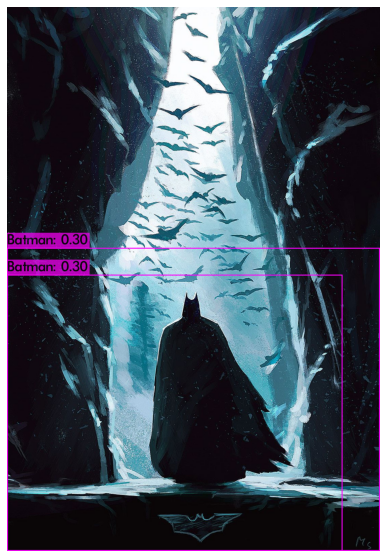

In [ ]:
imShow('predictions.jpg')

###Video Prediction

In [ ]:
%cd /content/darknet
output_video = '/content/results.avi'

!./darknet detector demo /content/darknet/data/obj.data /content/darknet/cfg/yolov3-custom.cfg /content/drive/MyDrive/yolov3_backup/yolov3-custom_last.weights /content/6.mp4 -dont_show -i 0 -out_filename $output_video